<a href="https://colab.research.google.com/github/Hanifanta/Customer-segmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objective**

Kasus ini mengharuskan untuk mengembangkan segmentasi pelanggan untuk memahami perilaku pelanggan dan memisahkan mereka dalam kelompok atau cluster yang berbeda sesuai dengan preferensi mereka, dan setelah pembagian selesai, informasi ini dapat diberikan kepada tim pemasaran sehingga mereka dapat merencanakan strategi yang sesuai.

Informasi dataset : 
https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

In [ ]:
# use to visualize missing value
!pip install missingno

## **Import Library**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import missingno as msno
## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

from scipy import stats
from scipy.stats import norm, skew 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
# clustering algorithms
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_samples, silhouette_score

## **Load Dataset**

In [ ]:
# load dataset

df = pd.read_csv("/content/Mall_Customers.csv")

## **Exploratory Data Analysis**

In [ ]:
# menampilkan isi dari dataframe

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# melihat jumlah data dan kolom pada dataframe

df.shape

(200, 5)

In [ ]:
# melihat informasi kolom pada dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


**Informasi kolom**

* CustomerID : ID customer
* Gender : Jenis kelamin customer
* Age : Umur customer
* Annual Income (k$) : Pendapat pertahun customer
* Spending Score (1-100) : Nilai pengeluaran customer dalam angka 1-100



In [ ]:
# menampilkan deskripsi statistik pada dataframe

df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [ ]:
# menampilkan tipe data pada dataframe

df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [ ]:
# menampilkan data yang bernilai null pada dataframe

df.isnull().sum().sort_values(ascending = False).head()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

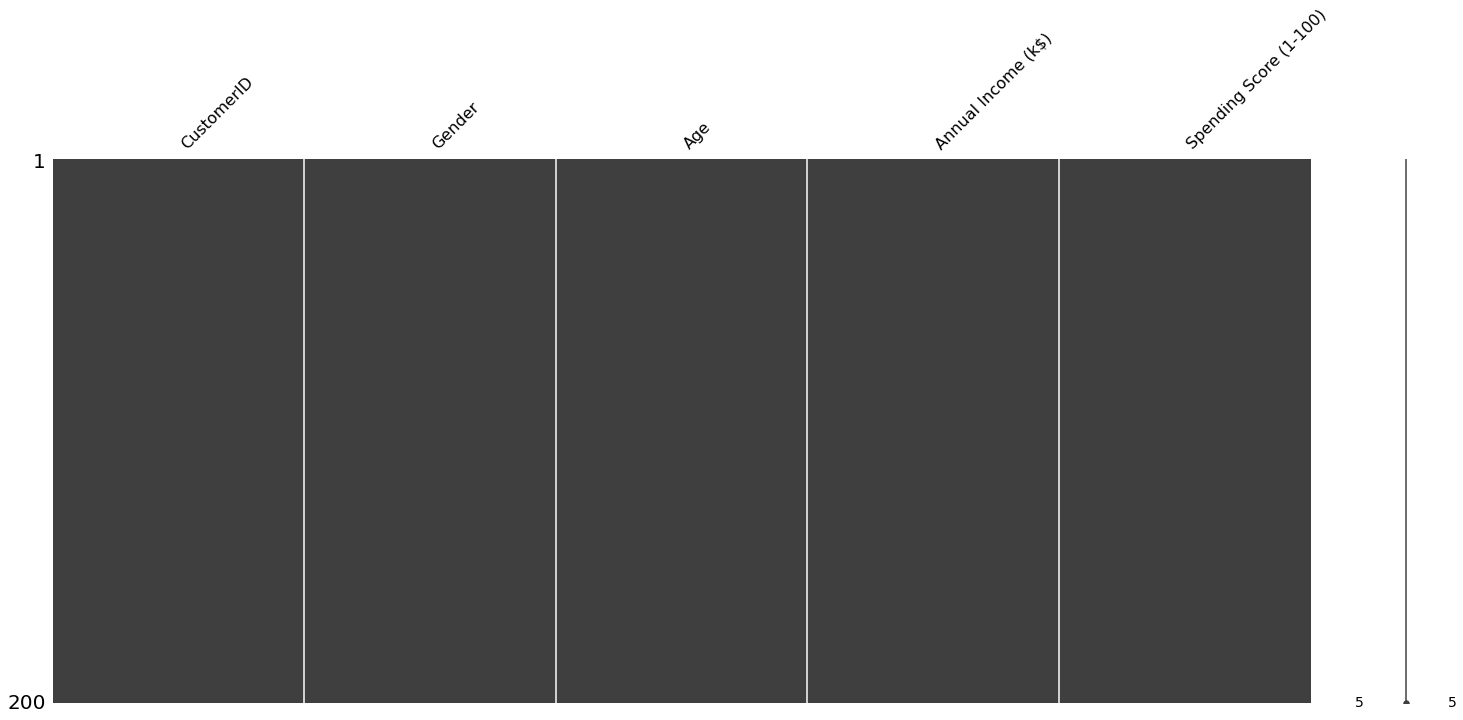

In [ ]:
# memvisualisasikan missing value pada dataframe

msno.matrix(df)

**Hasil dari Data exploration**

* Tidak ada nilai null
* Jumlah data adalah 200, dan jumlah kolom adalah 5
* Terdapat tipe data integer 4 dan 1 tipe data string



In [ ]:
# menampilkan visualisasi persebaran data

numerical_features = [col for col in df.columns if df[col].dtypes != 'O']
discrete_features = [col for col in numerical_features if len(df[col].unique()) < 10 and col not in ['CustomerID']]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features+['CustomerID']]
categorical_features = [col for col in df.columns if df[col].dtype == 'O']

print("Total kolom dengan nilai numerik : ",len(numerical_features))
print("Total discrete features : ",len(discrete_features))
print("Total continuous features : ", len(continuous_features))
print("Total categorical features : ",len(categorical_features))

Total kolom dengan nilai numerik :  4
Total discrete features :  0
Total continuous features :  3
Total categorical features :  1


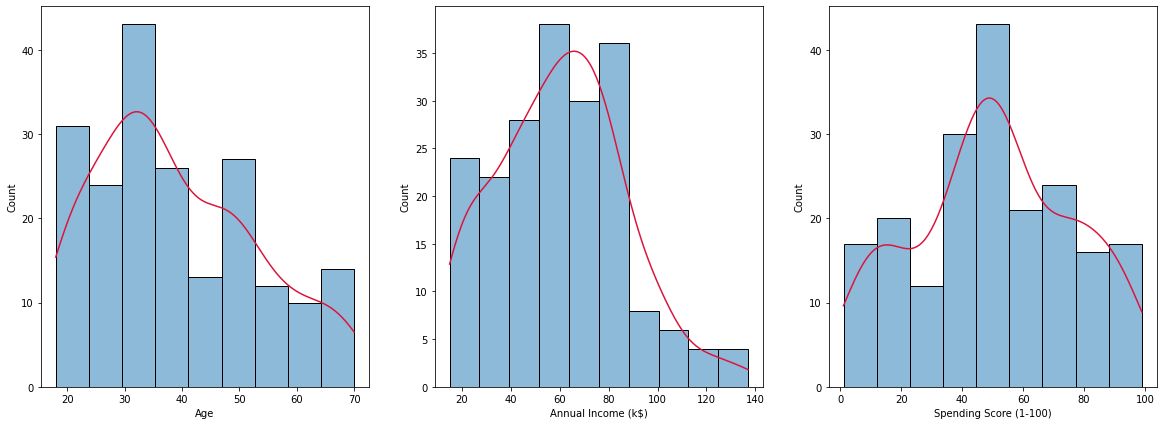

In [ ]:
# menampilkan visualisasi persebaran data

f, axes = plt.subplots(2,2 , figsize=(20, 7), sharex=False)
pos = 1
for i, feature in enumerate(continuous_features):

  plt.subplot(1 , 3 , pos)
  ax = sns.histplot(data=df, x = feature,kde=True,palette="husl")
  ax.lines[0].set_color('crimson')
  pos = pos + 1

In [ ]:
# mendapatkan fitur kecuali tipe objek
numeric_feats = df.dtypes[df.dtypes != 'object'].index

# cek skew dari fitur numerik
skewed_feats = df[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending = False)
print('\n Skew in numberical features: \n')
skewness_df = pd.DataFrame({'Skew' : skewed_feats})
print(skewness_df.head(10))


 Skew in numberical features: 

                            Skew
Age                     0.481919
Annual Income (k$)      0.319424
CustomerID              0.000000
Spending Score (1-100) -0.046865


Distribusi continous features terdistribusi secara normal.

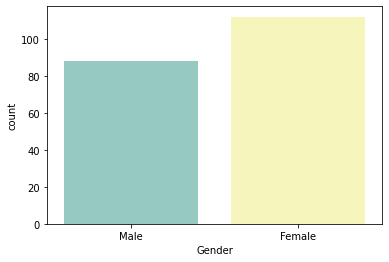

In [ ]:
# menampilkan distribusi fitur categorical

sns.countplot(x='Gender', data=df, palette="Set3")

Terlihat pada hasil plot, jenis kelamin perempuan lebih banyak pada dataframe.

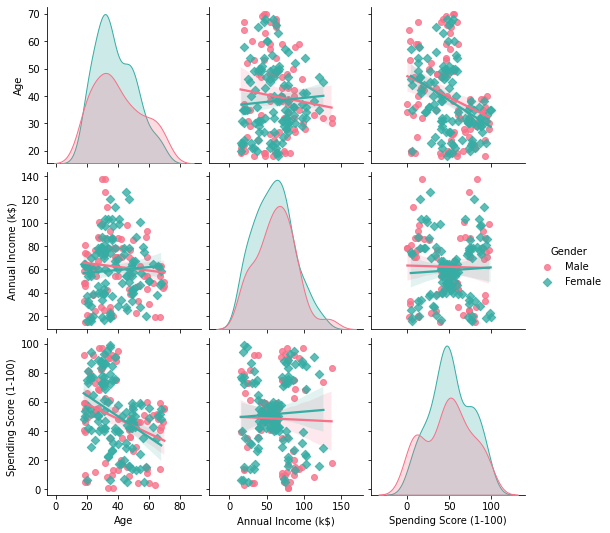

In [ ]:
# menampilkan visualisasi persebaran semua data yang dipengaruhi oleh kolom gender

sns.pairplot(df, 
             vars=["Age", "Annual Income (k$)", "Spending Score (1-100)"],  
             kind ="reg", 
             hue = "Gender", 
             palette="husl", 
             markers = ['o','D']
             )

Dari plot di atas, bahwa warna hijau memiliki rasio yang lebih tinggi daripada warna pink. Karena ada lebih banyak pelanggan perempuan daripada laki-laki.

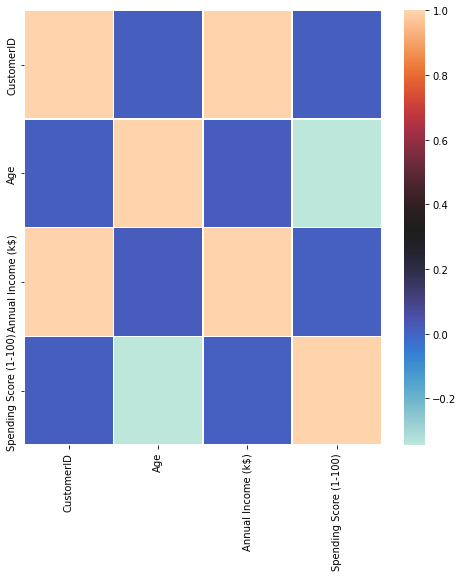

In [ ]:
# menampilkan korelasi data antar kolom

customer_corr = df.corr(method='spearman')
plt.figure(figsize=(8,8))
sns.heatmap(customer_corr, cmap="icefire", linewidths=.5) 

## **Select Features**

In [ ]:
# menghapus kolom yang tidak digunakan

df.drop(columns='CustomerID',axis=1,inplace=True)

In [ ]:
# generate dummy columns

df = pd.get_dummies(df).reset_index(drop=True)

In [ ]:
# Normalisasi data

pre_precessing_pipeline = make_pipeline(RobustScaler()) 

customer_scaled_df = pre_precessing_pipeline.fit_transform(df)

print(customer_scaled_df.shape)

(200, 5)


## **Modeling**

Pada tahap ini saya menerapkan dua Algoritma, dan akan membandingkan mana yang lebih baik. berikut Algoritma yang akan dipakai : 

* Agglomerative Clustering
* GaussianMixture Model based clustering

### **Hyperparameter Tuning**

Untuk menemukan nilai K terbaik, ada banyak teknik yang bisa digunakan.

* Elbow Method: Elbow Method menemukan nilai jumlah cluster yang optimal dengan menggunakan total nilai within-cluster sum of square.
* Average silhouette method : Ini adalah ukuran seberapa baik setiap titik data cocok dengan cluster yang sesuai. Metode ini mengevaluasi kualitas pengelompokan. Sebagai aturan umum, lebar siluet rata-rata yang tinggi menunjukkan output clustering yang lebih baik.
* Gap statistic method : Ini adalah ukuran nilai statistik gap. Gap statistic adalah perbedaan antara total perubahan intracluster untuk berbagai nilai k dibandingkan dengan nilai yang diharapkan. Jumlah cluster yang optimal adalah nilai yang memaksimalkan nilai statistik gap.
Disini kita akan menggunakan Elbow Method untuk menemukan nilai k terbaik.

dan pada kali ini saya menggunakan **Elbow method** untuk menemukan nilai K terbaik.

### **Elbow Method**

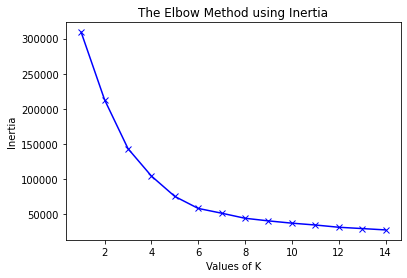

In [ ]:
inertia = []
range_val = range(1,15)
for i in range_val:
  kmean = KMeans(n_clusters=i)
  kmean.fit_predict(pd.DataFrame(df))
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

Dari Elbow method di atas, bahwa K = 5 adalah nilai K terbaik untuk clustering.

### **Agglomerative Clustering**

In [ ]:
# membuat cluster menggunakan algoritma agglomerative

agglo_model = AgglomerativeClustering(linkage="ward",n_clusters=5)
agglomerative_clusters = agglo_model.fit_predict(df)

### **GaussianMixture**

In [ ]:
# membuat cluster menggunakan algoritma GMM

GaussianMixture_model = GaussianMixture(n_components=5)
gmm_clusters = GaussianMixture_model.fit_predict(df)

## **Cluster Evaluation**

Untuk membandingkan algoritma clustering mana yang terbaik untuk modeling, saya menggunakan berbagai Cluster Validity Indices.
* Dunn Index
* Davies Bouldin Index
* Silhouette Score
* Calinski - Harabasz Index

"algorithms that produce clusters with high Dunn index are more desirable" -Wikipedia

"Objects with a high silhouette value are considered well clustered" -Wikipedia

"clustering algorithm that produces a collection of clusters with the smallest Davies–Bouldin index is considered the best algorithm" -Wikipedia

Di sini saya akan menggunakan metode **silhouette score** untuk memilih algoritma clustering terbaik.


In [ ]:
def silhouette_method(df,algo,y_pred):
  print('=================================================================================')
  print(algo,"silhouette score : ",silhouette_score(df,y_pred) )

silhouette_method(df,'Agglomerative',agglomerative_clusters)
silhouette_method(df,'GaussianMixture',gmm_clusters)
print('=================================================================================')

Agglomerative silhouette score :  0.43976347350045475
GaussianMixture silhouette score :  0.426670730014298


Dari hasil evaluasi di atas, bahwa algoritma **Agglomerative** memiliki silhouette score yang tinggi dibandingkan dengan GaussianMixture. Jadi saya akan menerapkan algoritma **Agglomerative** untuk modeling.

## **Cluster Visualization**

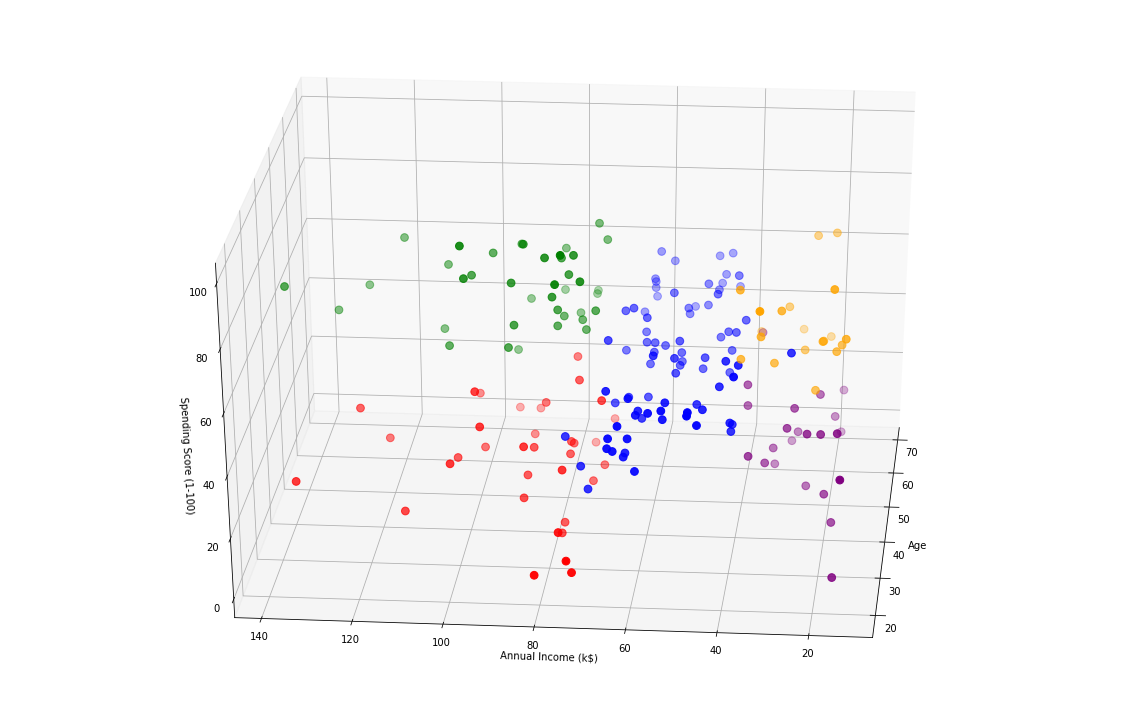

In [ ]:
df["label"] = agglomerative_clusters

fig = plt.figure(figsize=(20,13))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Age[df.label == 0], 
           df["Annual Income (k$)"][df.label == 0], 
           df["Spending Score (1-100)"][df.label == 0], 
           c='blue', s=60)
ax.scatter(df.Age[df.label == 1], 
           df["Annual Income (k$)"][df.label == 1], 
           df["Spending Score (1-100)"][df.label == 1], 
           c='red', s=60)
ax.scatter(df.Age[df.label == 2], 
           df["Annual Income (k$)"][df.label == 2], 
           df["Spending Score (1-100)"][df.label == 2], 
           c='green', s=60)
ax.scatter(df.Age[df.label == 3], 
           df["Annual Income (k$)"][df.label == 3], 
           df["Spending Score (1-100)"][df.label == 3], 
           c='orange', s=60)
ax.scatter(df.Age[df.label == 4], 
           df["Annual Income (k$)"][df.label == 4], 
           df["Spending Score (1-100)"][df.label == 4], 
           c='purple', s=60)
ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.show()

Berdasarkan dari hasil visualisasi cluster diatas, terlihat bahwa algoritma Agglomerative berhasil mengelompokan data menjadi 5 cluster. dan saya mengelompokan data berdasarkan Age, Annual Income, dan Spending score berdasarkan data pelanggan.


* Cluster 1 (Merah)
* Cluster 2 (Ungu)
* Cluster 3 (Biru)
* Cluster 4 (Kuning)
* Cluster 5 (Hijau)   

